In [6]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

import sys

from analysis import spikingResponse # custom object of trial-aligned spiking reponse
from analysis import pt, crosscorrel # plot_tools and CC-function

import matplotlib.pyplot as plt

# just to disable the HDMF cache namespace warnings, REMOVE to see them
import warnings
warnings.filterwarnings("ignore")

# 1) Loading the Optotagging results

In [7]:
#Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()
Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()

# randomly subsample the negative units to 100 cells per session
np.random.seed(1)
for key in ['PV','SST']:
    for n, nUnits in enumerate(Optotagging[key+'_negative_units']):
        Optotagging[key+'_negative_units'][n] = np.random.choice(nUnits, 100, replace=False)

# 2) Preprocess the stimulus-evoked spikes

In [89]:
all = True

tstart, tstop, dt = -1, 301, 1e-3
t = tstart+dt*np.arange(int((tstop-tstart)/dt))

if True:
    # turn True to re-run the analysis
    
    # load data from API
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
    data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
    manifest_path = os.path.join(data_directory, "manifest.json")
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    sessions = cache.get_session_table()
    
    for key in ['PV', 'SST']:
        # loop over session

        for sessionID, positive_units, negative_units in zip(Optotagging[key+'_sessions'],
                                                             Optotagging[key+'_positive_units'],
                                                             Optotagging[key+'_negative_units']):
            if all:
                units  = np.concatenate([positive_units, negative_units])
            else:
                units = positive_units
            
            session = cache.get_session_data(sessionID)
            # stimulus infos for that session
            stim_table = session.get_stimulus_table()
            # fetch summary statistics 
            analysis_metrics = cache.get_unit_analysis_metrics_by_session_type(session.session_type)
            
            for protocol in [\
                             #'natural_movie_one_more_repeats',
                             'natural_movie_two',
                             #'natural_movie_one',
                             'natural_movie_three']:
                if protocol in np.unique(stim_table.stimulus_name):
                    cond = (stim_table.stimulus_name==protocol)
                    # get the number of repeats
                    blocks = np.unique(stim_table[cond].stimulus_block)
                    print(sessionID, protocol, 'n=%i blocks' % len(blocks))
                    for unit in units:
                        spike_matrix = np.zeros((len(blocks),len(t)), dtype=bool)
                        # get the spikes of that unit
                        spike_times = session.spike_times[unit]
                        # then just iterate over stimulus block:
                        for trial_idx, b in enumerate(blocks):
                            bCond = cond & (stim_table.stimulus_block==b)
                            trial_start = np.min(stim_table[bCond].start_time)
                            #tstop = np.max(stim_table[bCond].stop_time)
                            in_range = (spike_times > (trial_start + t[0])) * \
                                       (spike_times < (trial_start + t[-1]))
                            binned_times = ((spike_times[in_range] -\
                                             (trial_start + t[0])) / dt).astype('int')
                            spike_matrix[trial_idx, binned_times] = True      
                        Data = {'time_resolution':dt, 
                                'spike_matrix':spike_matrix,
                                't':t, 'keys':['t', 'spike_matrix']}
                        np.save(os.path.join('..', 'data', 'visual_coding', key,
                                             '%s_unit_%i.npy' % (protocol, unit)),
                                Data)

721123822 natural_movie_three n=2 blocks
746083955 natural_movie_three n=2 blocks
760345702 natural_movie_three n=2 blocks
773418906 natural_movie_three n=2 blocks
797828357 natural_movie_three n=2 blocks
715093703 natural_movie_three n=2 blocks
719161530 natural_movie_three n=2 blocks
756029989 natural_movie_three n=2 blocks
758798717 natural_movie_three n=2 blocks
760693773 natural_movie_three n=2 blocks
762602078 natural_movie_three n=2 blocks


# 2) Compute the PSTH

In [10]:
# loop over frames to build the time course
RATES = {}
for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    RATES[key+'_posUnits'] = []
    RATES[key+'_negUnits'] = []
    for sessionID in range(len(Optotagging[key+'_sessions'])):
        for u, rates, units, c in zip(range(2), [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                               [Optotagging[key+'_positive_units'][sessionID], Optotagging[key+'_negative_units'][sessionID]],
                               [color, 'tab:grey']):
            for unit in units:
                for protocol in ['natural_movie_one', 'natural_movie_one_more_repeats']:
                    filename = os.path.join('..', 'data', 'visual_coding', key, 
                                            '%s_unit_%i.npy' % (protocol, unit))
                    if os.path.isfile(filename):
                        spikeResp = spikingResponse(None, None, None, filename=filename)
                        rates.append(spikeResp.get_rate(smoothing=5e-3))
RATES['time'] = spikeResp.t
np.save(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'), RATES)

## 2') Compute the PSTH per session

In [125]:
# loop over frames to build the time course
PROTOCOLS = {'natural_movie_three':['natural_movie_three'],
             'natural_movie_one':['natural_movie_one', 'natural_movie_one_more_repeats']}

for p in PROTOCOLS:
    
    protocols = PROTOCOLS[p]
    
    RATES = {}
    for k, key, color in zip(range(2),
                             ['PV', 'SST'],
                             ['tab:red','tab:orange']):

        RATES['%s_posUnits' % key] = []
        RATES['%s_negUnits' % key] = []

        for sessionID in range(len(Optotagging[key+'_sessions'])):

            posUnits = Optotagging[key+'_positive_units'][sessionID]
            negUnits = Optotagging[key+'_negative_units'][sessionID]
            posRates, negRates = [], []

            for protocol in protocols:

                for units, rates in zip([negUnits, posUnits], [negRates, posRates]):
                    for unit in units:
                        filename = os.path.join('..', 'data', 'visual_coding', key, 
                                                '%s_unit_%i.npy' % (protocol, unit))
                        if os.path.isfile(filename):
                            spikeResp = spikingResponse(None, None, None, filename=filename)
                            rates.append(spikeResp.get_rate(smoothing=5e-3))

            if (len(posRates)>1):
                # only if more than one positive units
                RATES['%s_posUnits' % key].append(np.mean(posRates, axis=0))
                RATES['%s_negUnits' % key].append(np.mean(negRates, axis=0))

    RATES['time'] = spikeResp.t
    np.save(os.path.join('..', 'data', 'visual_coding',
                         'RATES_per_session_%s.npy' % p), RATES)

# 3) Plot

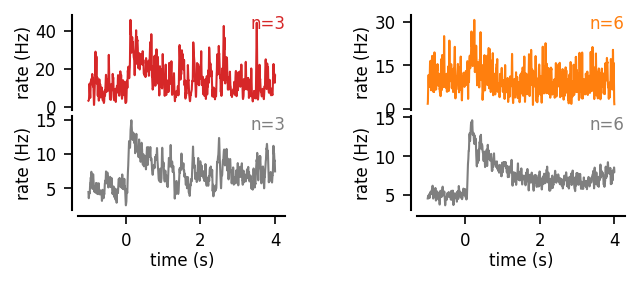

In [127]:
RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_per_session_natural_movie_three.npy'),
                allow_pickle=True).item()

fig, AX = pt.figure(axes=(2,2), hspace=0.1, figsize=(1.3,1))

tCond = RATES['time']<4

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    for u, rates, c in zip(range(2), 
                           [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                           [color, 'tab:grey']):  
        if len(rates)>1:
            pt.plot(RATES['time'][tCond], np.mean(rates, axis=0)[tCond],
                    #sy=0.*np.std(rates, axis=0)[tCond],
                    ax=AX[u][k], color=c)
            pt.annotate(AX[u][k], 'n=%i' % len(rates), (1,1), va='top', ha='right', color=c)
            pt.set_plot(AX[u][k], ['left','bottom'] if u else ['left'], 
                        ylabel='rate (Hz)', xlabel='time (s)' if u else '')


Text(0.5, 0.98, 'cross-correl. "-" vs "+" units')

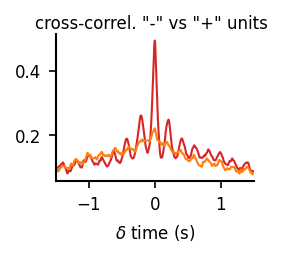

In [93]:
fig, ax = plt.subplots(1) # pt.figure()
ax.set_xlabel('$\delta$ time (s)')
CCF, time_shift = crosscorrel(np.mean(RATES['PV_negUnits'], axis=0),
                              np.mean(RATES['PV_posUnits'], axis=0),
                              1.5, RATES['time'][1]-RATES['time'][0])
ax.plot(time_shift, CCF, color='tab:red')

CCF, time_shift = crosscorrel(np.mean(RATES['SST_negUnits'], axis=0),
                              np.mean(RATES['SST_posUnits'], axis=0),
                              1.5, RATES['time'][1]-RATES['time'][0])
#ax2 = ax.twinx()
ax.plot(time_shift, CCF, color='tab:orange')
ax.set_xlim([-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')

## Cross-correlation per session

In [132]:
CCs = {'dt':RATES['time'][1]-RATES['time'][0],
       'extent':1.5}

for key in ['PV', 'SST']:
    for u in ['pos', 'neg']:
        CCs[key+'_%sUnits' % u] = []

for p in PROTOCOLS:
    
    RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_per_session_%s.npy' % p),
                    allow_pickle=True).item()

    for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):

        for u in ['pos', 'neg']:
            
            for negRate, rate in zip(RATES['%s_negUnits' % key], RATES['%s_%sUnits' % (key,u)]):
                CCs[key+'_%sUnits' % u].append(\
                                crosscorrel(negRate, rate, CCs['extent'], CCs['dt'])[0])
                
# just to get the time shift
_, CCs['time_shift'] = crosscorrel(0*RATES['time'], 0*RATES['time'], CCs['extent'], CCs['dt'])

np.save(os.path.join('..', 'data', 'visual_coding', 'CC_per_session_natural_movies.npy'), CCs)

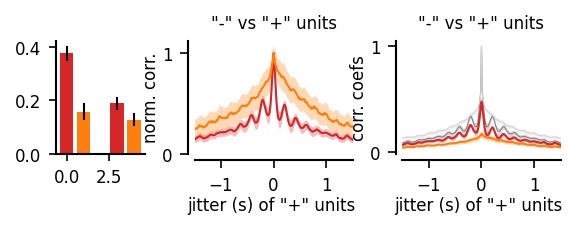

In [156]:
from scipy import stats

CCs = np.load(os.path.join('..', 'data', 'visual_coding', 'CC_per_session_natural_movies.npy'),
              allow_pickle=True).item()

Windows = [[-0.05, 0.05],
           [0.1, 0.3]]

fig, [ax1, ax2,ax3] = pt.figure(axes_extents=[[[2,1],[3,1],[3,1]]],
                            figsize=(.2,1.2), wspace=4.)

for w, window in enumerate(Windows):
    mX, sX = [], []
    tCond = (CCs['time_shift']>window[0]) & (CCs['time_shift']<window[1])
    for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
        mX = np.mean([np.mean(cc[tCond]) for cc in CCs[key+'_posUnits']])        
        sX = stats.sem([np.mean(cc[tCond]) for cc in CCs[key+'_posUnits']])
        ax1.bar([3*w+k], [mX], yerr=[sX], color=color)

for k, key, color1, color2 in zip(range(2),
                                  ['PV', 'SST'],
                                  ['tab:red','tab:orange'],
                                  ['tab:grey', 'lightgray']):
    mean = np.mean(CCs[key+'_posUnits'], axis=0)
    pt.plot(CCs['time_shift'], mean/np.max(mean),
            sy=stats.sem(CCs[key+'_negUnits'], axis=0)/np.max(mean),
            color=color1, ax=ax2)
    mean = np.mean(CCs[key+'_negUnits'], axis=0)
    pt.plot(CCs['time_shift'], mean/np.max(mean), 
            sy=stats.sem(CCs[key+'_negUnits'], axis=0)/np.max(mean),
            color=color2, lw=0.5, ax=ax3)
    pt.plot(CCs['time_shift'], np.mean(CCs[key+'_posUnits'], axis=0), 
            sy=stats.sem(CCs[key+'_posUnits'], axis=0)/np.max(mean),
            color=color1, ax=ax3)
    
pt.set_plot(ax2, xlabel='jitter (s) of "+" units ', 
            title='"-" vs "+" units', ylabel='norm. corr.',
            xlim=[-1.5,1.5], yticks=[0,1])
pt.set_plot(ax3, xlabel='jitter (s) of "+" units ', 
            title='"-" vs "+" units', ylabel='corr. coefs',
            xlim=[-1.5,1.5], yticks=[0,1])
#pt.set_plot(ax, xlabel='jitter (s)', xlim=[-0.3,0.3])

#fig.suptitle('cross-correl. "-" vs "+" units')

In [145]:
X

[[0.2149363907450396,
  0.09286309892003444,
  0.12340517153033292,
  0.20373802771567237,
  0.21967458531167985,
  0.10431724322428121,
  0.18582390009334698,
  0.25724405922086946,
  0.30283941963254113],
 [0.1388719067031461,
  -0.033203071624007284,
  0.16728370455698524,
  0.049283360661028085,
  0.0565731979808348,
  0.044227667928074525,
  0.1365693370499208,
  -0.003109887509846987,
  0.23685406865638214,
  0.06449076056932253,
  0.0304286144782978,
  0.04645655450152722,
  0.21426668454365647,
  0.10471682145128433,
  0.2934078187235125,
  0.1854285723752592,
  0.33948057917462116,
  0.2239555590145888]]

## Cross-correlation per cell

In [40]:
from scipy import signal

window = [-1.5, 1.5]

CCs = {'dt':RATES['time'][1]-RATES['time'][0],
       'extent':1.5}

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    
    popRate = np.mean(RATES['%s_negUnits' % key], axis=0)

    # positive units
    CCs[key+'_posUnits'], CCs['time_shift'] = crosscorrel(popRate, popRate, CCs['extent'], CCs['dt'])
    
    # loop over negative units
    CCs[key+'_negUnits'] = []
    for rate in RATES['%s_negUnits' % key]:
        CCs[key+'_negUnits'].append(\
                        crosscorrel(popRate, rate, CCs['extent'], CCs['dt'])[0])
        
np.save(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'), CCs)

Text(0.5, 0.98, 'cross-correl. "-" vs "+" units')

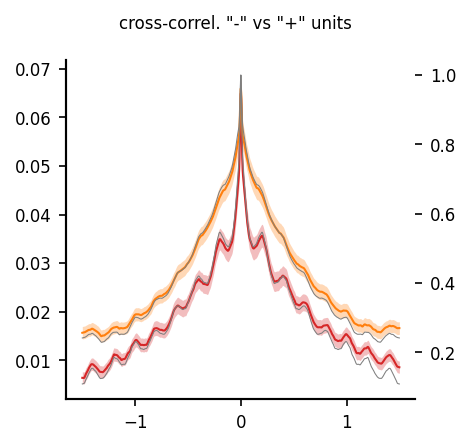

In [45]:
CCs = np.load(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'),
              allow_pickle=True).item()

fig, ax = plt.subplots(1, figsize=(3,3))
ax2 = ax.twinx()

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    pt.plot(CCs['time_shift'], np.mean(CCs[key+'_negUnits'], axis=0), 
            sy=stats.sem(CCs[key+'_negUnits'], axis=0), color=color, ax=ax)
    pt.plot(CCs['time_shift'], CCs[key+'_posUnits'], 
            color='tab:grey', lw=0.5, ax=ax2)
    
#pt.set_plot(ax, xlabel='$\delta$ time (s)', xlim=[-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')